In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from script.text_cleaning import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\likah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_sms = pd.read_csv("data/final.csv", encoding="ISO-8859-1", index_col=0)
df_sms.rename(columns={'v2':'text'}, inplace = True)
df_sms.head(5)

,text,spam
0,"Dear Homeowner, Interest Rates are at thei...",1
1,Help wanted. We are a 14 year old fortune 500...,1
2,Subject: ua 4 for meter 8608 - 6 / 98 - deal 9...,0
3,Subject: fw : pymt for 03 / 01 sales adjustmen...,0
4,Sean O'Donnell wrote: > Doesnt answer your qu...,0


In [3]:
print(df_sms["spam"].value_counts())

1    3000
0    3000
Name: spam, dtype: int64


# BERT (fine-tuned)

In [4]:
from script.text_cleaning import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [5]:
df_sms = text_preprocess(df_sms,'text')
df_sms.head()

,text,spam
0,dear homeowner interest rates lowest point 40 ...,1
1,help wanted we 14 year old fortune 500 company...,1
2,subject ua 4 meter 8608 6 98 deal 96731 daren ...,0
3,subject fw pymt 03 01 sales adjustment cowtrap...,0
4,sean o donnell wrote doesnt answer question th...,0


In [6]:
# Tokenization
from transformers import AutoTokenizer
# Load Model
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_sms,test_size=0.3,random_state=42,shuffle=True,stratify=df_sms.spam)

In [8]:
max_len = 50

In [9]:
X_train = tokenizer(train_df.text.to_list(),
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=True,
                   verbose=True)

X_test = tokenizer(test_df.text.to_list(),
                  max_length=max_len,
                  padding='max_length',
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=True,
                  verbose=True)

In [10]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')
token_type_ids = Input(shape=(max_len,),dtype=tf.int32,name='token_type_ids')

In [11]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

embeddings = model.bert({'input_ids': input_ids, 'attention_mask':attention_mask})[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=256,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=2,activation='sigmoid')(output)


model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [12]:
checkpoint_filepath = 'model/bert_finetune'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_balanced_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

metrics = BinaryAccuracy('balanced_accuracy')
loss = BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# start training model
r = model.fit(x = {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']}, y = to_categorical(train_df.spam),
          epochs=5,
          validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, to_categorical(test_df.spam)),
            callbacks = [model_checkpoint_callback])

Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 0.2512 - balanced_accuracy: 0.8856 

INFO:tensorflow:Assets written to: model\bert_finetune\assets


INFO:tensorflow:Assets written to: model\bert_finetune\assets


132/132 [==============================] - 2103s 15s/step - loss: 0.2512 - balanced_accuracy: 0.8856 - val_loss: 0.1428 - val_balanced_accuracy: 0.9547
Epoch 2/5
132/132 [==============================] - ETA: 0s - loss: 0.0598 - balanced_accuracy: 0.9808 

INFO:tensorflow:Assets written to: model\bert_finetune\assets


INFO:tensorflow:Assets written to: model\bert_finetune\assets


132/132 [==============================] - 1786s 14s/step - loss: 0.0598 - balanced_accuracy: 0.9808 - val_loss: 0.1108 - val_balanced_accuracy: 0.9661
Epoch 3/5
132/132 [==============================] - 1729s 13s/step - loss: 0.0216 - balanced_accuracy: 0.9929 - val_loss: 0.1485 - val_balanced_accuracy: 0.9633
Epoch 4/5
132/132 [==============================] - 1723s 13s/step - loss: 0.0072 - balanced_accuracy: 0.9983 - val_loss: 0.1764 - val_balanced_accuracy: 0.9628
Epoch 5/5
132/132 [==============================] - 1917s 15s/step - loss: 0.0056 - balanced_accuracy: 0.9976 - val_loss: 0.1891 - val_balanced_accuracy: 0.9619


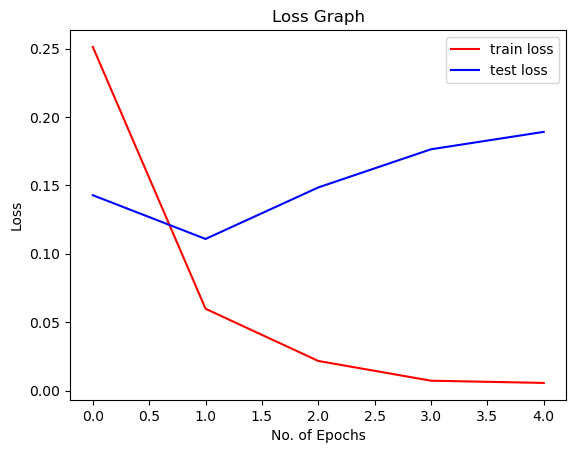

In [14]:
import matplotlib.pyplot as plt

plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

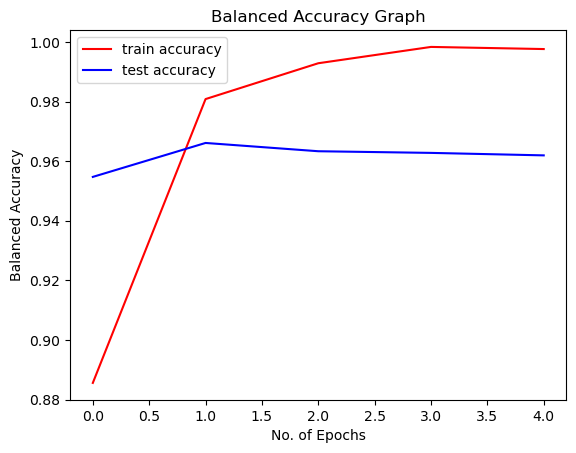

In [15]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

### Testing

In [16]:
model_pred = tf.keras.models.load_model("model/bert_finetune")

In [18]:
loss, acc = model_pred.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.spam))
print("Test Binary Crossentropy Loss:", loss)
print("Test Binary Accuracy:", acc)

57/57 [==============================] - 158s 3s/step - loss: 0.1108 - balanced_accuracy: 0.9661
Test Binary Crossentropy Loss: 0.11081447452306747
Test Binary Accuracy: 0.9661111235618591


In [19]:
test_predictions = model_pred.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.spam,test_predictions))
print("Classification Report:")
print(classification_report(test_df.spam,test_predictions, digits = 4))

57/57 [==============================] - 156s 3s/step
Confusion Matrix:
[[879  21]
 [ 40 860]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9565    0.9767    0.9665       900
           1     0.9762    0.9556    0.9657       900

    accuracy                         0.9661      1800
   macro avg     0.9663    0.9661    0.9661      1800
weighted avg     0.9663    0.9661    0.9661      1800

